In [1]:
import os
import sys
import pathlib
import pickle as pkl
import json
import itertools

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

import torch
import torchvision

from torch.utils.data import DataLoader, Subset

from arch import backbones, heads, models

from tqdm import tqdm

import utils.time
import utils.dict

from time import time
from datetime import datetime

import pprint

---

# Load experiment data

In [2]:
def load_json_dict(
        json_filename
        ):

    with open(json_filename, 'r') as json_file:
        json_dict = json.load(json_file)

    return json_dict

In [3]:
exp_data_all = {}

In [4]:
exp_data_all["ret_train"] = {}

exp_dirname = os.path.join(pathlib.Path.home(), "data", "fashion_retrieval", "ret_train")

backbone_list = [
    "resnet_50",
    "efficientnet_b3",
    "convnext_t"
]

exp_idxs_list = [
    list(range(9)),
    list(range(12)),
    list(range(13))
]

for backbone, exp_idxs in zip(backbone_list, exp_idxs_list):

    exp_data_all["ret_train"][backbone] = {}
    
    for exp_idx in exp_idxs:

        exp_filename = os.path.join(exp_dirname, backbone, "test_{:03d}".format(exp_idx), "exp_data.json")
        if not os.path.exists(exp_filename):
            exp_filename = os.path.join(exp_dirname, backbone, "test_{:03d}".format(exp_idx), "train_ret_DDP_data.json")

        exp_data = load_json_dict(exp_filename)

        exp_data_all["ret_train"][backbone]["exp_{:03d}".format(exp_idx)] = exp_data

In [5]:
exp_data_all["ret_train_extra"] = {}

exp_dirname = os.path.join(pathlib.Path.home(), "data", "fashion_retrieval", "ret_train_extra")

backbone_list = [
    "efficientnet_b2",
    "efficientnet_b3",
    "efficientnet_b4"
]

exp_idxs_list = [
    list(range(2)),
    list(range(2)),
    list(range(2))
]

for backbone, exp_idxs in zip(backbone_list, exp_idxs_list):

    exp_data_all["ret_train_extra"][backbone] = {}
    
    for exp_idx in exp_idxs:

        exp_filename = os.path.join(exp_dirname, backbone, "test_{:03d}".format(exp_idx), "exp_data.json")
        if not os.path.exists(exp_filename):
            exp_filename = os.path.join(exp_dirname, backbone, "exp_{:03d}".format(exp_idx), "train_ret_DDP__data.json")

        exp_data = load_json_dict(exp_filename)

        exp_data_all["ret_train_extra"][backbone]["exp_{:03d}".format(exp_idx)] = exp_data

---

# Single loss plots

In [ ]:
exp_data = exp_data_all["ret_train_extra"]["efficientnet_b2"]["exp_000"]

###

fig, ax = plt.subplots(figsize=(24, 8))

mean_train_loss_list =\
    list(map(np.mean, exp_data["results"]["stage_1"]["train_mean_loss_list"])) +\
    list(map(np.mean, exp_data["results"]["stage_2"]["train_mean_loss_list"]))

mean_val_loss_list =\
    list(map(np.mean, exp_data["results"]["stage_1"]["val_mean_loss_list"])) +\
    list(map(np.mean, exp_data["results"]["stage_2"]["val_mean_loss_list"]))

stage_1_epochs = exp_data["results"]["stage_1"]["num_epochs"]

ax.plot(range(1, len(mean_train_loss_list) + 1), mean_train_loss_list, label="train_loss", marker=".")
ax.plot(range(1, len(mean_val_loss_list) + 1), mean_val_loss_list, label="val_loss", marker=".")

ax.axvline(stage_1_epochs, ymin=0.02, ymax=0.98, color="black", linestyle="--")

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

ax.set_yscale("log")

ax.grid()
ax.legend()

backbone = exp_data["settings"]["backbone"]["class"]
batch_size_1 = exp_data["settings"]["stage_1"]["data_loading"]["batch_size"]
#grad_acc_iters_1 = utils.dict.chain_get(exp_data, "settings", "stage_1", "max_acc_iter", default=1)
grad_acc_iters_1 = utils.dict.chain_get(exp_data, "settings", "stage_1", "data_loading", "grad_acc_iters", default=1)
batch_size_2 = exp_data["settings"]["stage_2"]["data_loading"]["batch_size"]
#grad_acc_iters_2 = utils.dict.chain_get(exp_data, "settings", "stage_2", "max_acc_iter", default=1)
grad_acc_iters_2 = utils.dict.chain_get(exp_data, "settings", "stage_2", "data_loading", "grad_acc_iters", default=1)
lr_1 = exp_data["settings"]["stage_1"]["optimizer"]["lr"]
lr_2 = exp_data["settings"]["stage_2"]["optimizer"]["lr"]

title = "Backbone: {:s}\nBatch size: {:d} ({:d}) / {:d} ({:d})\nLearning rate: {:.1e} / {:.1e}".format(
    backbone,
    batch_size_1,
    grad_acc_iters_1,
    batch_size_2,
    grad_acc_iters_2,
    lr_1,
    lr_2
)

ax.set_title(title)

plt.show()

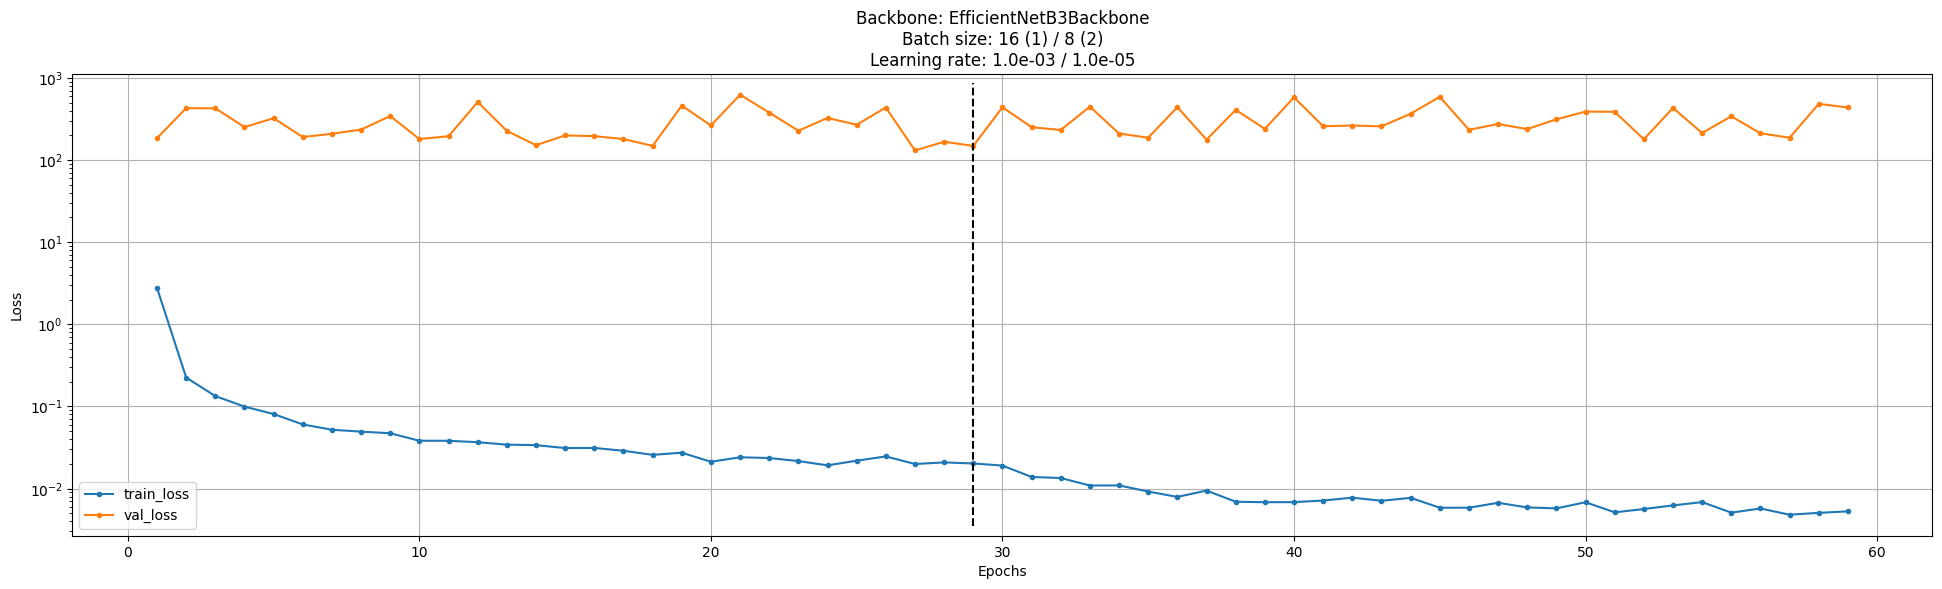

In [16]:
exp_data = exp_data_all["ret_train_extra"]["efficientnet_b3"]["exp_000"]

###

fig, ax = plt.subplots(figsize=(24, 6))

mean_train_loss_list =\
    list(map(np.mean, exp_data["results"]["stage_1"]["train_mean_loss_list"])) +\
    list(map(np.mean, exp_data["results"]["stage_2"]["train_mean_loss_list"]))

mean_val_loss_list =\
    list(map(np.mean, exp_data["results"]["stage_1"]["val_mean_loss_list"])) +\
    list(map(np.mean, exp_data["results"]["stage_2"]["val_mean_loss_list"]))

stage_1_epochs = exp_data["results"]["stage_1"]["num_epochs"]

ax.plot(range(1, len(mean_train_loss_list) + 1), mean_train_loss_list, label="train_loss", marker=".")
ax.plot(range(1, len(mean_val_loss_list) + 1), mean_val_loss_list, label="val_loss", marker=".")

ax.axvline(stage_1_epochs, ymin=0.02, ymax=0.98, color="black", linestyle="--")

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

ax.set_yscale("log")

ax.grid()
ax.legend()

backbone = exp_data["settings"]["backbone"]["class"]
batch_size_1 = exp_data["settings"]["stage_1"]["data_loading"]["batch_size"]
#grad_acc_iters_1 = utils.dict.chain_get(exp_data, "settings", "stage_1", "max_acc_iter", default=1)
grad_acc_iters_1 = utils.dict.chain_get(exp_data, "settings", "stage_1", "data_loading", "grad_acc_iters", default=1)
batch_size_2 = exp_data["settings"]["stage_2"]["data_loading"]["batch_size"]
#grad_acc_iters_2 = utils.dict.chain_get(exp_data, "settings", "stage_2", "max_acc_iter", default=1)
grad_acc_iters_2 = utils.dict.chain_get(exp_data, "settings", "stage_2", "data_loading", "grad_acc_iters", default=1)
lr_1 = exp_data["settings"]["stage_1"]["optimizer"]["lr"]
lr_2 = exp_data["settings"]["stage_2"]["optimizer"]["lr"]

title = "Backbone: {:s}\nBatch size: {:d} ({:d}) / {:d} ({:d})\nLearning rate: {:.1e} / {:.1e}".format(
    backbone,
    batch_size_1,
    grad_acc_iters_1,
    batch_size_2,
    grad_acc_iters_2,
    lr_1,
    lr_2
)

ax.set_title(title)

plt.show()

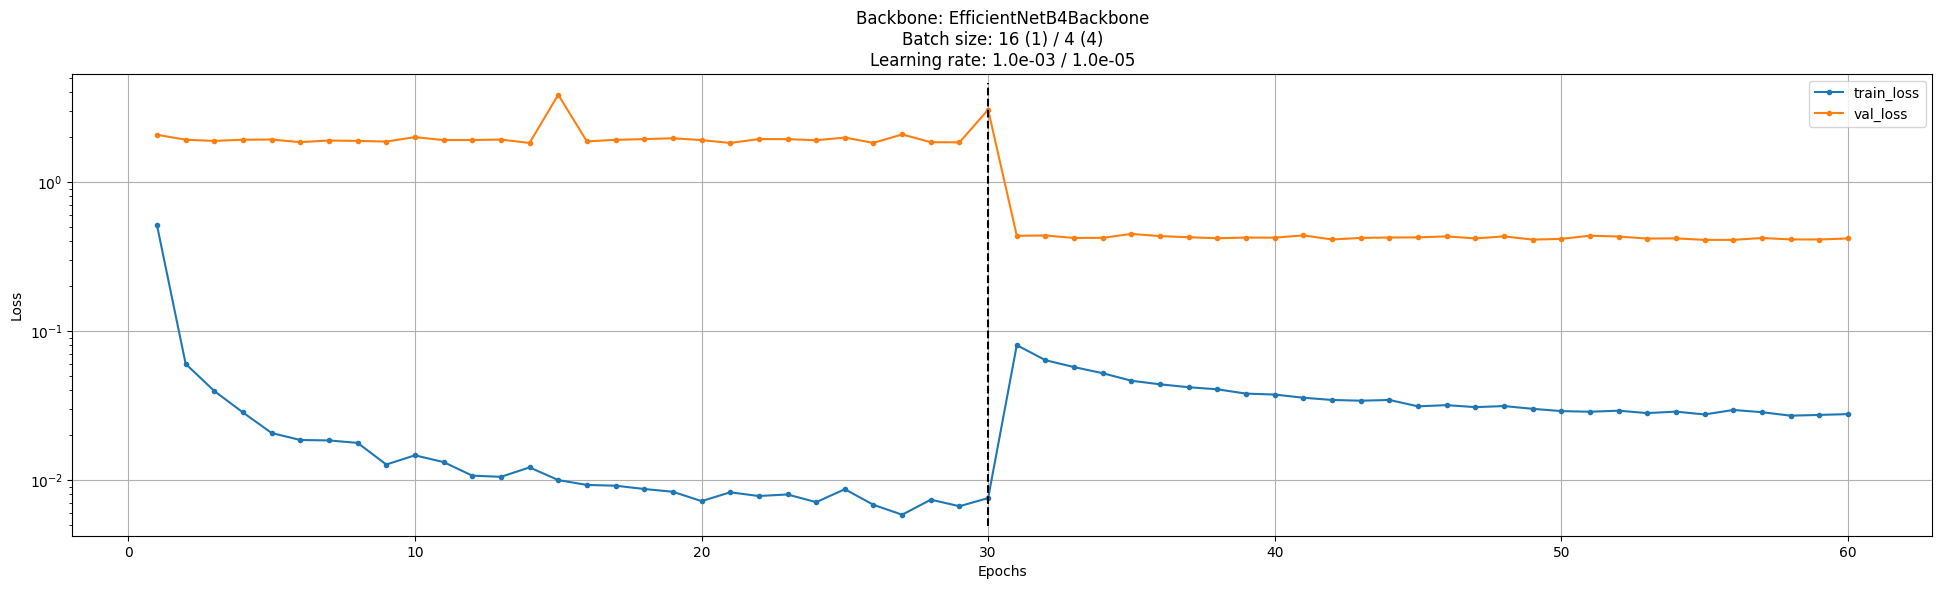

In [17]:
exp_data = exp_data_all["ret_train_extra"]["efficientnet_b4"]["exp_000"]

###

fig, ax = plt.subplots(figsize=(24, 6))

mean_train_loss_list =\
    list(map(np.mean, exp_data["results"]["stage_1"]["train_mean_loss_list"])) +\
    list(map(np.mean, exp_data["results"]["stage_2"]["train_mean_loss_list"]))

mean_val_loss_list =\
    list(map(np.mean, exp_data["results"]["stage_1"]["val_mean_loss_list"])) +\
    list(map(np.mean, exp_data["results"]["stage_2"]["val_mean_loss_list"]))

stage_1_epochs = exp_data["results"]["stage_1"]["num_epochs"]

ax.plot(range(1, len(mean_train_loss_list) + 1), mean_train_loss_list, label="train_loss", marker=".")
ax.plot(range(1, len(mean_val_loss_list) + 1), mean_val_loss_list, label="val_loss", marker=".")

ax.axvline(stage_1_epochs, ymin=0.02, ymax=0.98, color="black", linestyle="--")

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

ax.set_yscale("log")

ax.grid()
ax.legend()

backbone = exp_data["settings"]["backbone"]["class"]
batch_size_1 = exp_data["settings"]["stage_1"]["data_loading"]["batch_size"]
#grad_acc_iters_1 = utils.dict.chain_get(exp_data, "settings", "stage_1", "max_acc_iter", default=1)
grad_acc_iters_1 = utils.dict.chain_get(exp_data, "settings", "stage_1", "data_loading", "grad_acc_iters", default=1)
batch_size_2 = exp_data["settings"]["stage_2"]["data_loading"]["batch_size"]
#grad_acc_iters_2 = utils.dict.chain_get(exp_data, "settings", "stage_2", "max_acc_iter", default=1)
grad_acc_iters_2 = utils.dict.chain_get(exp_data, "settings", "stage_2", "data_loading", "grad_acc_iters", default=1)
lr_1 = exp_data["settings"]["stage_1"]["optimizer"]["lr"]
lr_2 = exp_data["settings"]["stage_2"]["optimizer"]["lr"]

title = "Backbone: {:s}\nBatch size: {:d} ({:d}) / {:d} ({:d})\nLearning rate: {:.1e} / {:.1e}".format(
    backbone,
    batch_size_1,
    grad_acc_iters_1,
    batch_size_2,
    grad_acc_iters_2,
    lr_1,
    lr_2
)

ax.set_title(title)

plt.show()

# Many single loss plots

In [ ]:
exp_data_list = []

for exp_data_all_2 in exp_data_all.values():
    for exp_data in exp_data_all_2.values():
        exp_data_list.append(exp_data)

###

for exp_data in exp_data_list:
        
    fig, ax = plt.subplots(figsize=(24, 8))

    mean_train_loss_list =\
        list(map(np.mean, exp_data["results"]["stage_1"]["train_mean_loss_list"])) +\
        list(map(np.mean, exp_data["results"]["stage_2"]["train_mean_loss_list"]))

    mean_val_loss_list =\
        list(map(np.mean, exp_data["results"]["stage_1"]["val_mean_loss_list"])) +\
        list(map(np.mean, exp_data["results"]["stage_2"]["val_mean_loss_list"]))

    stage_1_epochs = exp_data["results"]["stage_1"]["num_epochs"]

    ax.plot(range(1, len(mean_train_loss_list) + 1), mean_train_loss_list, label="train_loss", marker=".")
    ax.plot(range(1, len(mean_val_loss_list) + 1), mean_val_loss_list, label="val_loss", marker=".")

    ax.axvline(stage_1_epochs, ymin=0.02, ymax=0.98, color="black", linestyle="--")

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")

    ax.set_yscale("log")

    ax.grid()
    ax.legend()

    title = "Backbone: {:s}\nBatch size: {:d} ({:d}) / {:d} ({:d})\nLearning rate: {:.1e} / {:.1e}".format(
        exp_data["settings"]["backbone"]["class"],
        exp_data["settings"]["stage_1"]["data_loading"]["batch_size"],
        utils.dict.chain_get(exp_data, "settings", "stage_1", "max_acc_iter", default=1),
        exp_data["settings"]["stage_2"]["data_loading"]["batch_size"],
        utils.dict.chain_get(exp_data, "settings", "stage_2", "max_acc_iter", default=1),
        exp_data["settings"]["stage_1"]["optimizer"]["lr"],
        exp_data["settings"]["stage_2"]["optimizer"]["lr"]
    )

    ax.set_title(title)

    plt.show()

---

# Multiple loss plots

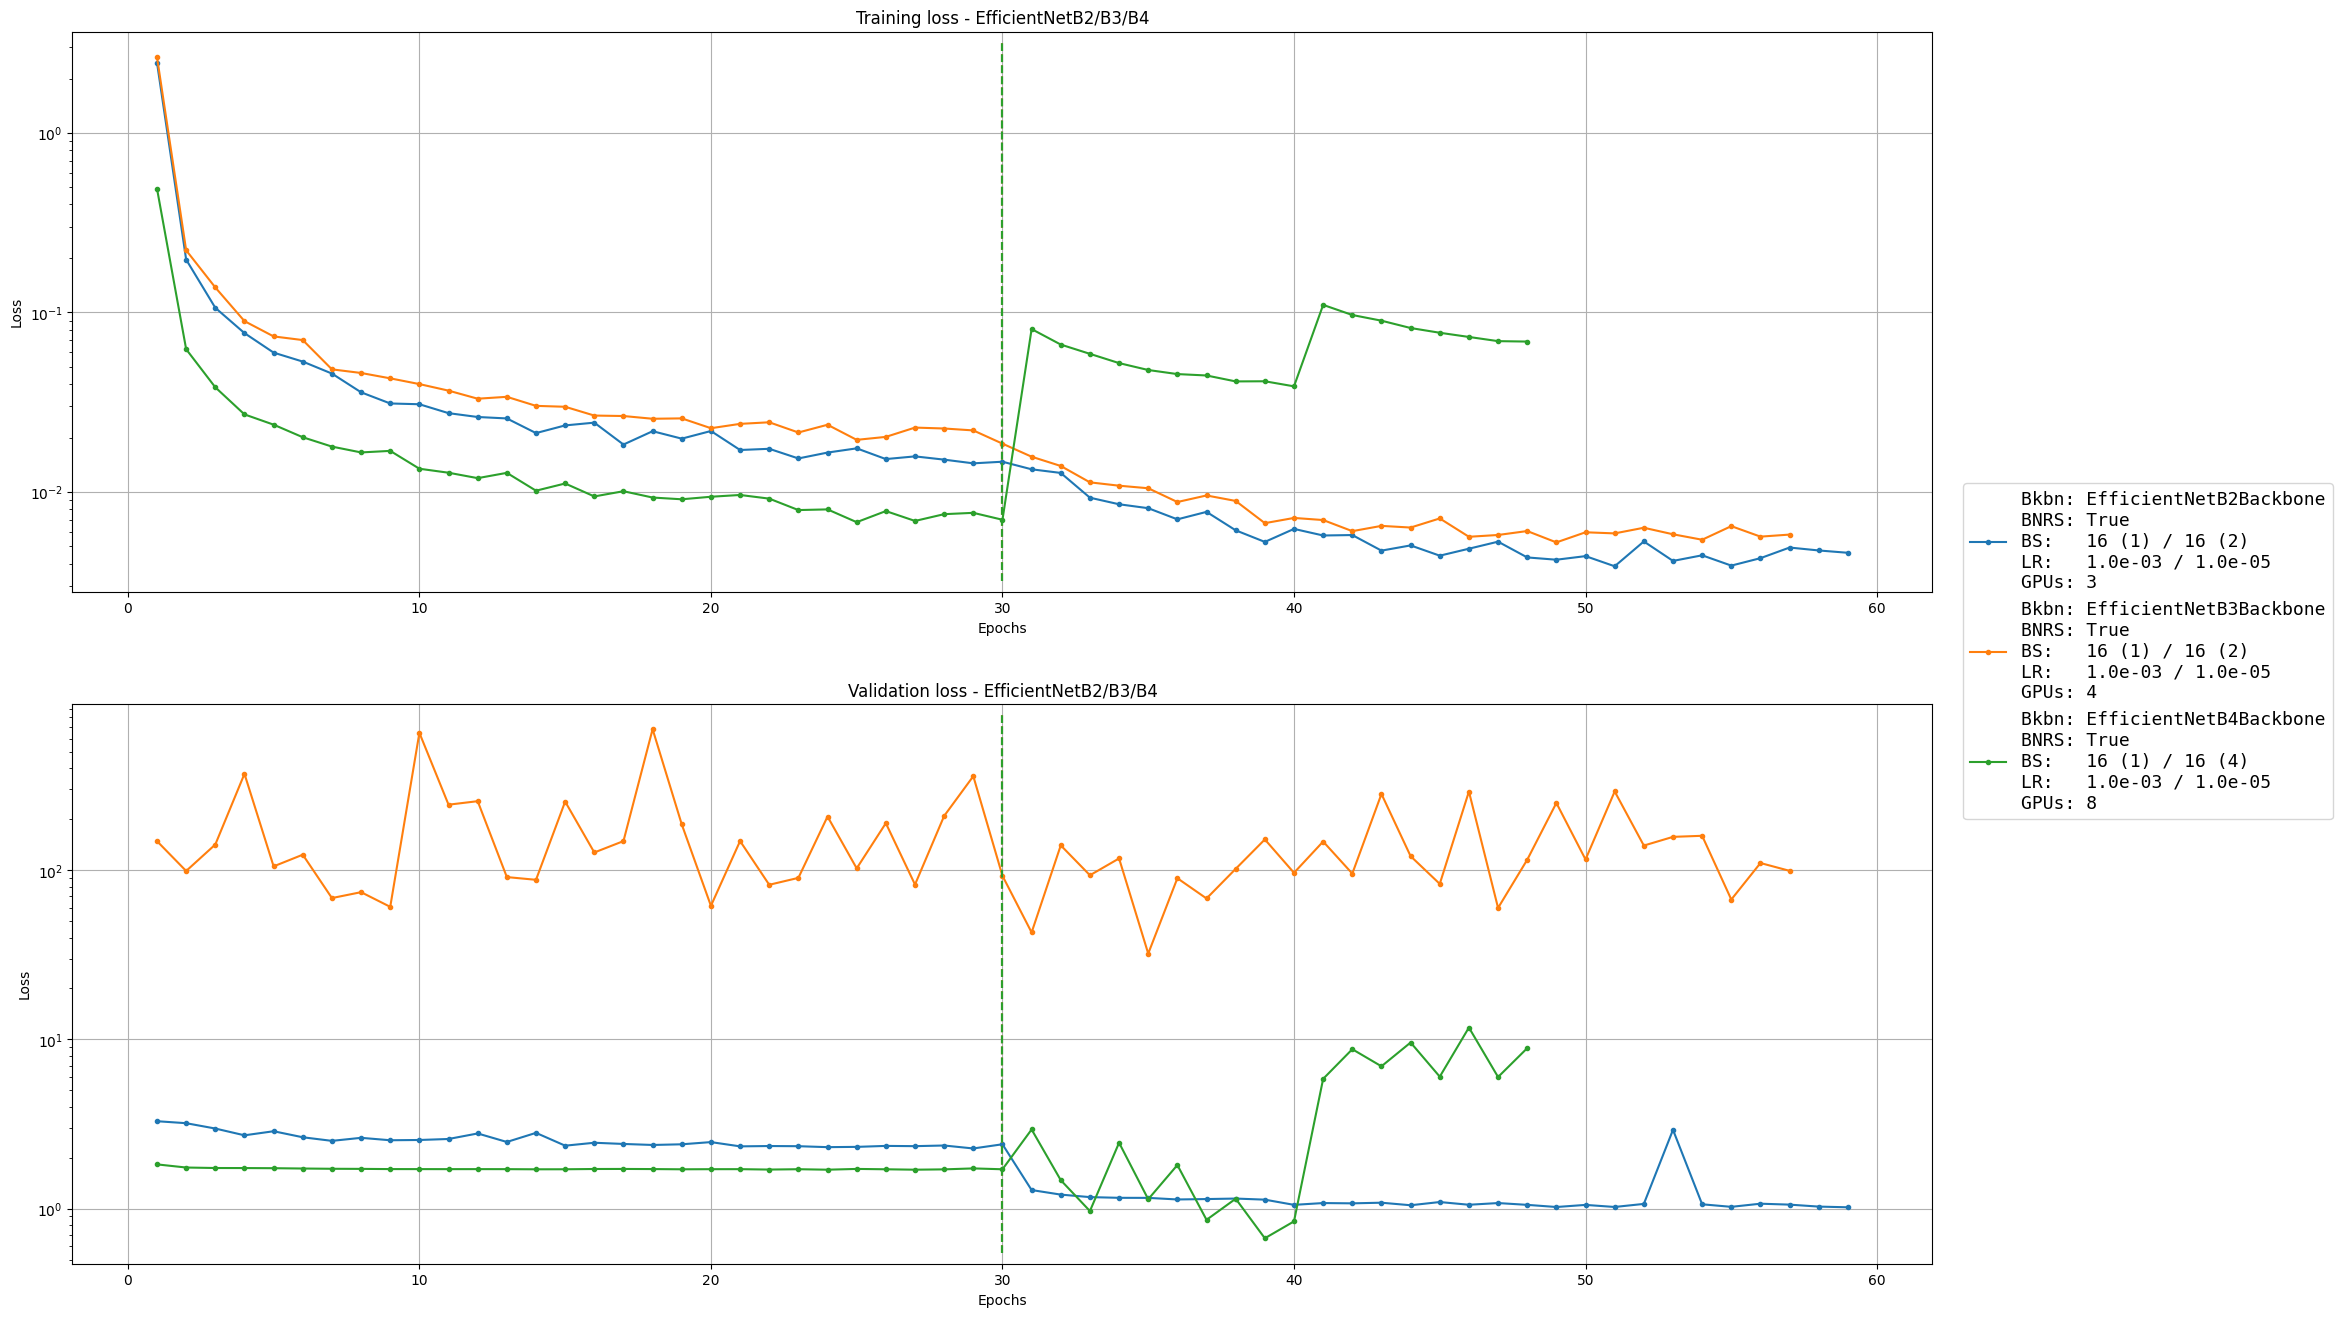

In [41]:
exp_data_list = []

for exp_data in exp_data_all["ret_train_extra"].values():
    exp_data_list.append(exp_data["exp_000"])

###

fig, axs = plt.subplots(figsize=(24, 16), nrows=2)

cmap = mpl.colormaps["tab10"]
#color_list = [cmap(x) for x in np.linspace(0, 1, len(exp_data_list))]
color_list = [cmap(x) for x in np.linspace(0, 1, 10)]

for exp_data_idx, exp_data in enumerate(exp_data_list):

    backbone = exp_data["settings"]["backbone"]["class"]
    bnrs = utils.dict.chain_get(exp_data, "settings", "backbone", "batchnorm_track_runnning_stats", default=True)
    batch_size_1 = exp_data["settings"]["stage_1"]["data_loading"]["batch_size"]
    batch_size_2 = exp_data["settings"]["stage_2"]["data_loading"]["batch_size"]
    #grad_acc_iters_1 = utils.dict.chain_get(exp_data, "settings", "stage_1", "max_acc_iter", default=1)
    grad_acc_iters_1 = utils.dict.chain_get(exp_data, "settings", "stage_1", "data_loading", "grad_acc_iters", default=1)
    #grad_acc_iters_2 = utils.dict.chain_get(exp_data, "settings", "stage_2", "max_acc_iter", default=1)
    grad_acc_iters_2 = utils.dict.chain_get(exp_data, "settings", "stage_2", "data_loading", "grad_acc_iters", default=1)
    lr_1 = exp_data["settings"]["stage_1"]["optimizer"]["lr"]
    lr_2 = exp_data["settings"]["stage_2"]["optimizer"]["lr"]
    num_gpus = len(exp_data["settings"]["gpu_usage"])

    title_lines = []
    title_lines.append("Bkbn: {:s}".format(backbone))
    title_lines.append("BNRS: {:s}".format(str(bnrs)))
    title_lines.append("BS:   {:2d} ({:d}) / {:2d} ({:d})".format(
        batch_size_1 * grad_acc_iters_1,
        grad_acc_iters_1,
        batch_size_2 * grad_acc_iters_2,
        grad_acc_iters_2
    ))
    title_lines.append("LR:   {:.1e} / {:.1e}".format(
        lr_1,
        lr_2
    ))
    title_lines.append("GPUs: {:d}".format(num_gpus))

    label = "\n".join(title_lines)
    
    mean_train_loss_list =\
        list(map(np.mean, exp_data["results"]["stage_1"]["train_mean_loss_list"])) +\
        list(map(np.mean, exp_data["results"]["stage_2"]["train_mean_loss_list"]))

    mean_val_loss_list =\
        list(map(np.mean, exp_data["results"]["stage_1"]["val_mean_loss_list"])) +\
        list(map(np.mean, exp_data["results"]["stage_2"]["val_mean_loss_list"]))
    
    stage_1_epochs = exp_data["results"]["stage_1"]["num_epochs"]

    color = color_list[exp_data_idx]

    axs[0].plot(range(1, len(mean_train_loss_list) + 1), mean_train_loss_list, label=label, color=color, marker=".")
    axs[1].plot(range(1, len(mean_val_loss_list) + 1), mean_val_loss_list, label=label, color=color, marker=".")

    axs[0].axvline(stage_1_epochs, ymin=0.02, ymax=0.98, color=color, linestyle="--")
    axs[1].axvline(stage_1_epochs, ymin=0.02, ymax=0.98, color=color, linestyle="--")

for ax in axs:

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")

    ax.set_yscale("log")

    ax.grid()

axs[0].set_title("Training loss - EfficientNetB2/B3/B4")
axs[1].set_title("Validation loss - EfficientNetB2/B3/B4")

#

plt.legend(prop={'family': 'monospace', "size": 13}, bbox_to_anchor=(1.22, 1.41))

#

plt.show()

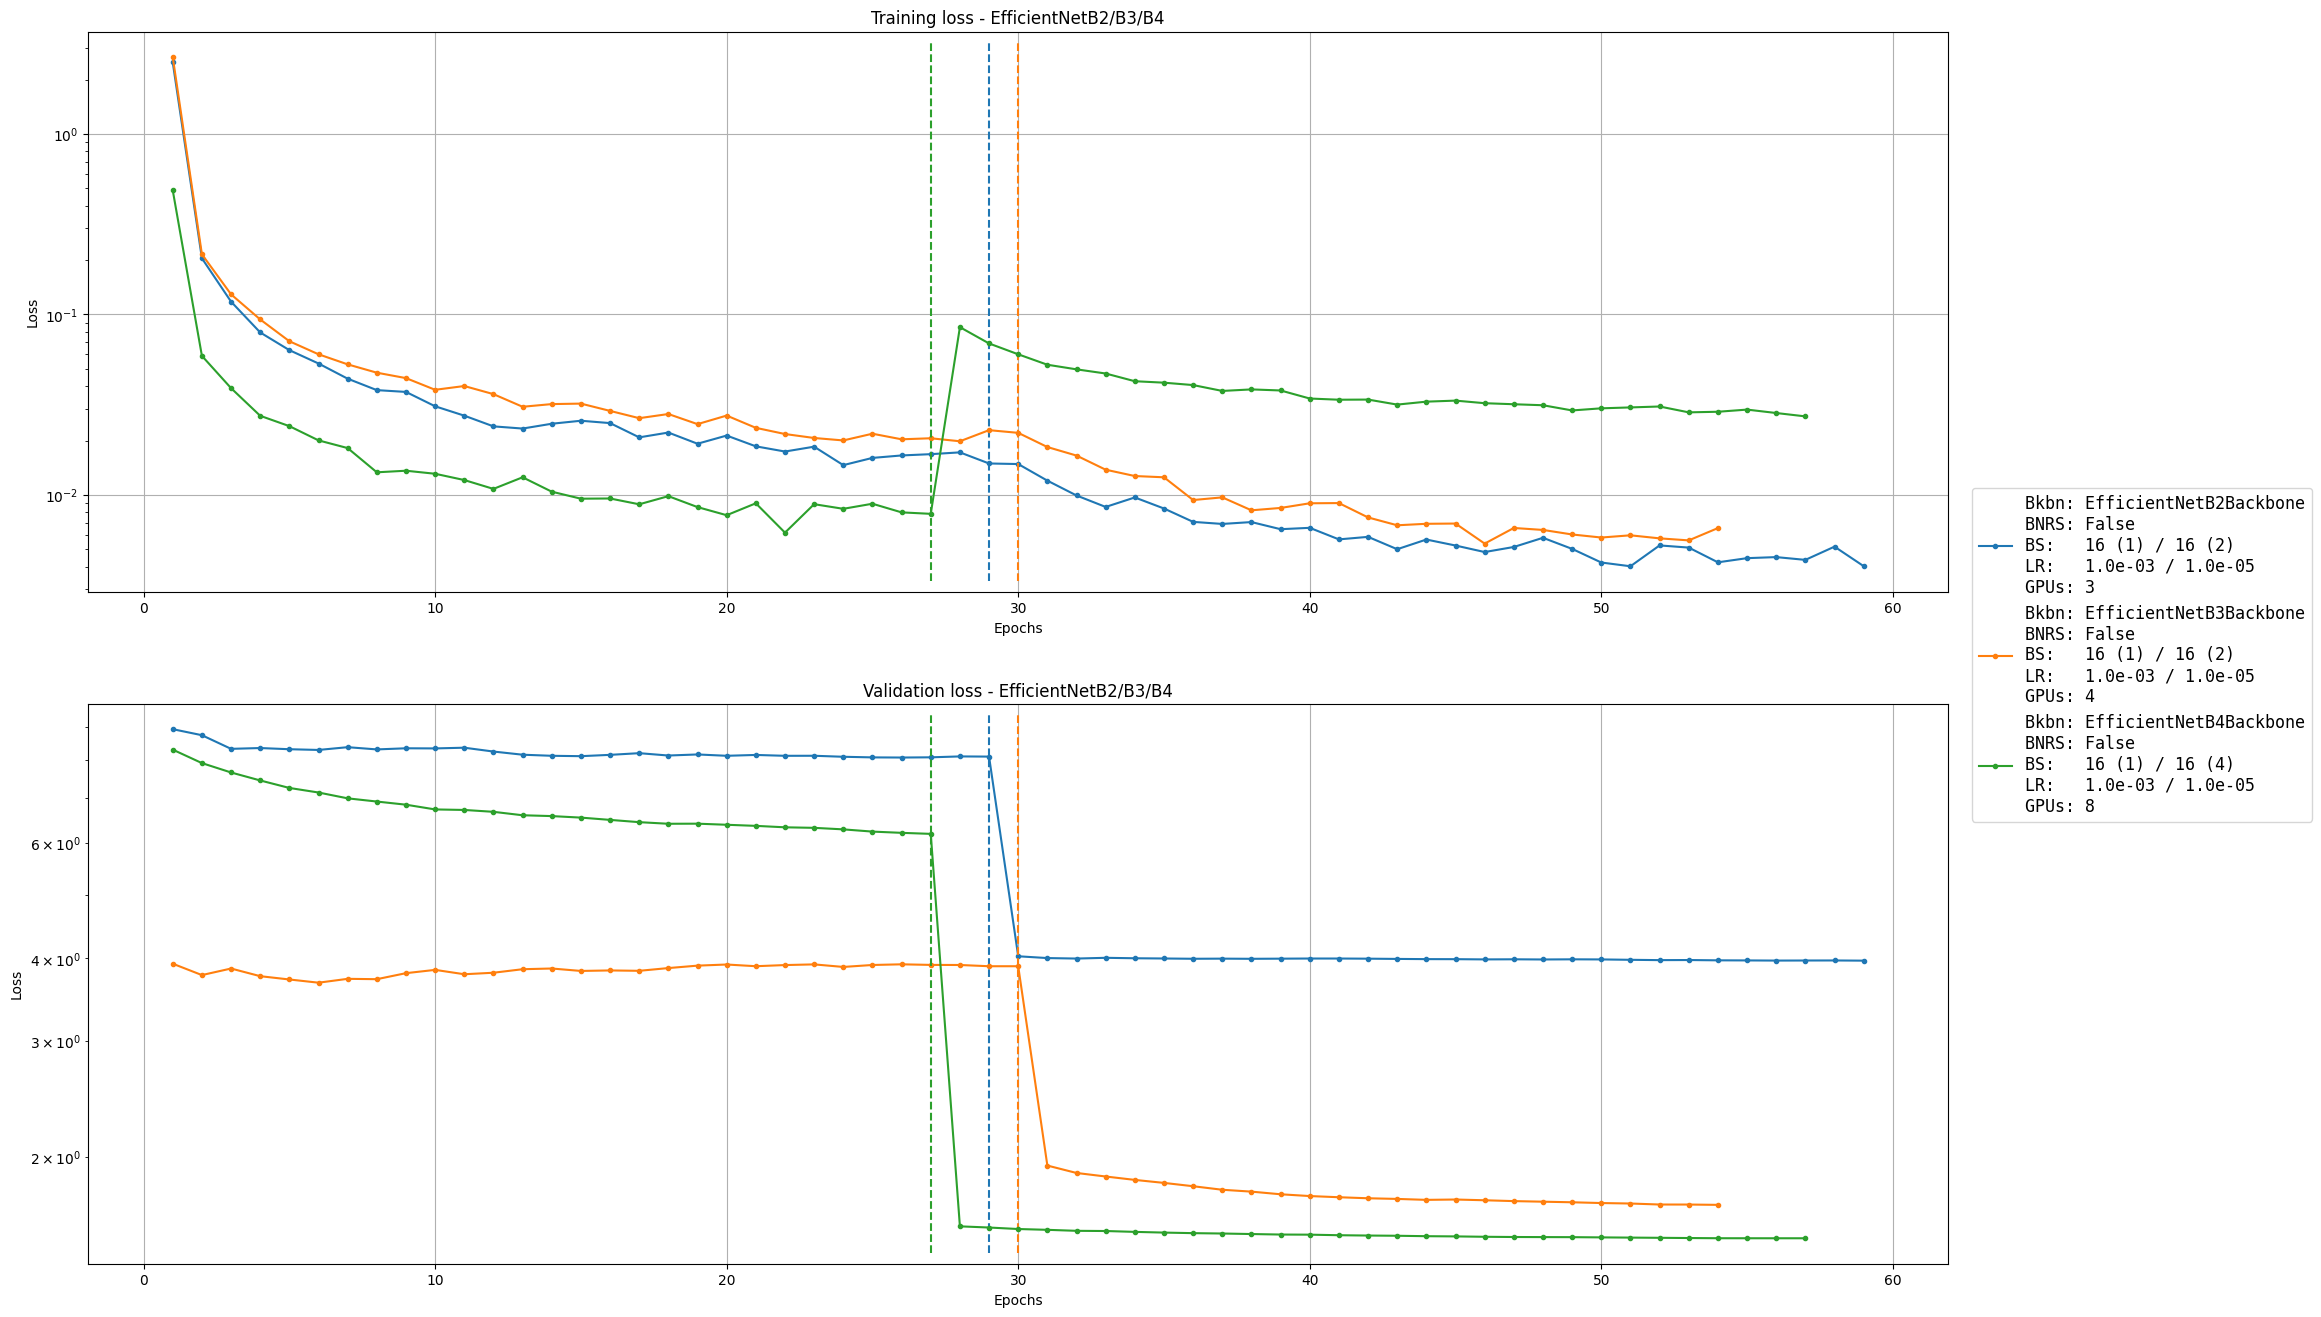

In [31]:
exp_data_list = []

for exp_data in exp_data_all["ret_train_extra"].values():
    exp_data_list.append(exp_data["exp_001"])

###

fig, axs = plt.subplots(figsize=(24, 16), nrows=2)

cmap = mpl.colormaps["tab10"]
#color_list = [cmap(x) for x in np.linspace(0, 1, len(exp_data_list))]
color_list = [cmap(x) for x in np.linspace(0, 1, 10)]

for exp_data_idx, exp_data in enumerate(exp_data_list):

    backbone = exp_data["settings"]["backbone"]["class"]
    bnrs = utils.dict.chain_get(exp_data, "settings", "backbone", "batchnorm_track_runnning_stats", default=True)
    batch_size_1 = exp_data["settings"]["stage_1"]["data_loading"]["batch_size"]
    batch_size_2 = exp_data["settings"]["stage_2"]["data_loading"]["batch_size"]
    #grad_acc_iters_1 = utils.dict.chain_get(exp_data, "settings", "stage_1", "max_acc_iter", default=1)
    grad_acc_iters_1 = utils.dict.chain_get(exp_data, "settings", "stage_1", "data_loading", "grad_acc_iters", default=1)
    #grad_acc_iters_2 = utils.dict.chain_get(exp_data, "settings", "stage_2", "max_acc_iter", default=1)
    grad_acc_iters_2 = utils.dict.chain_get(exp_data, "settings", "stage_2", "data_loading", "grad_acc_iters", default=1)
    lr_1 = exp_data["settings"]["stage_1"]["optimizer"]["lr"]
    lr_2 = exp_data["settings"]["stage_2"]["optimizer"]["lr"]
    num_gpus = len(exp_data["settings"]["gpu_usage"])

    title_lines = []
    title_lines.append("Bkbn: {:s}".format(backbone))
    title_lines.append("BNRS: {:s}".format(str(bnrs)))
    title_lines.append("BS:   {:2d} ({:d}) / {:2d} ({:d})".format(
        batch_size_1 * grad_acc_iters_1,
        grad_acc_iters_1,
        batch_size_2 * grad_acc_iters_2,
        grad_acc_iters_2
    ))
    title_lines.append("LR:   {:.1e} / {:.1e}".format(
        lr_1,
        lr_2
    ))
    title_lines.append("GPUs: {:d}".format(num_gpus))

    label = "\n".join(title_lines)
    
    mean_train_loss_list =\
        list(map(np.mean, exp_data["results"]["stage_1"]["train_mean_loss_list"])) +\
        list(map(np.mean, exp_data["results"]["stage_2"]["train_mean_loss_list"]))

    mean_val_loss_list =\
        list(map(np.mean, exp_data["results"]["stage_1"]["val_mean_loss_list"])) +\
        list(map(np.mean, exp_data["results"]["stage_2"]["val_mean_loss_list"]))
    
    stage_1_epochs = exp_data["results"]["stage_1"]["num_epochs"]

    color = color_list[exp_data_idx]

    axs[0].plot(range(1, len(mean_train_loss_list) + 1), mean_train_loss_list, label=label, color=color, marker=".")
    axs[1].plot(range(1, len(mean_val_loss_list) + 1), mean_val_loss_list, label=label, color=color, marker=".")

    axs[0].axvline(stage_1_epochs, ymin=0.02, ymax=0.98, color=color, linestyle="--")
    axs[1].axvline(stage_1_epochs, ymin=0.02, ymax=0.98, color=color, linestyle="--")

for ax in axs:

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")

    ax.set_yscale("log")

    ax.grid()

axs[0].set_title("Training loss - EfficientNetB2/B3/B4")
axs[1].set_title("Validation loss - EfficientNetB2/B3/B4")

#

plt.legend(prop={'family': 'monospace', "size": 13}, bbox_to_anchor=(1.22, 1.41))

#

plt.show()

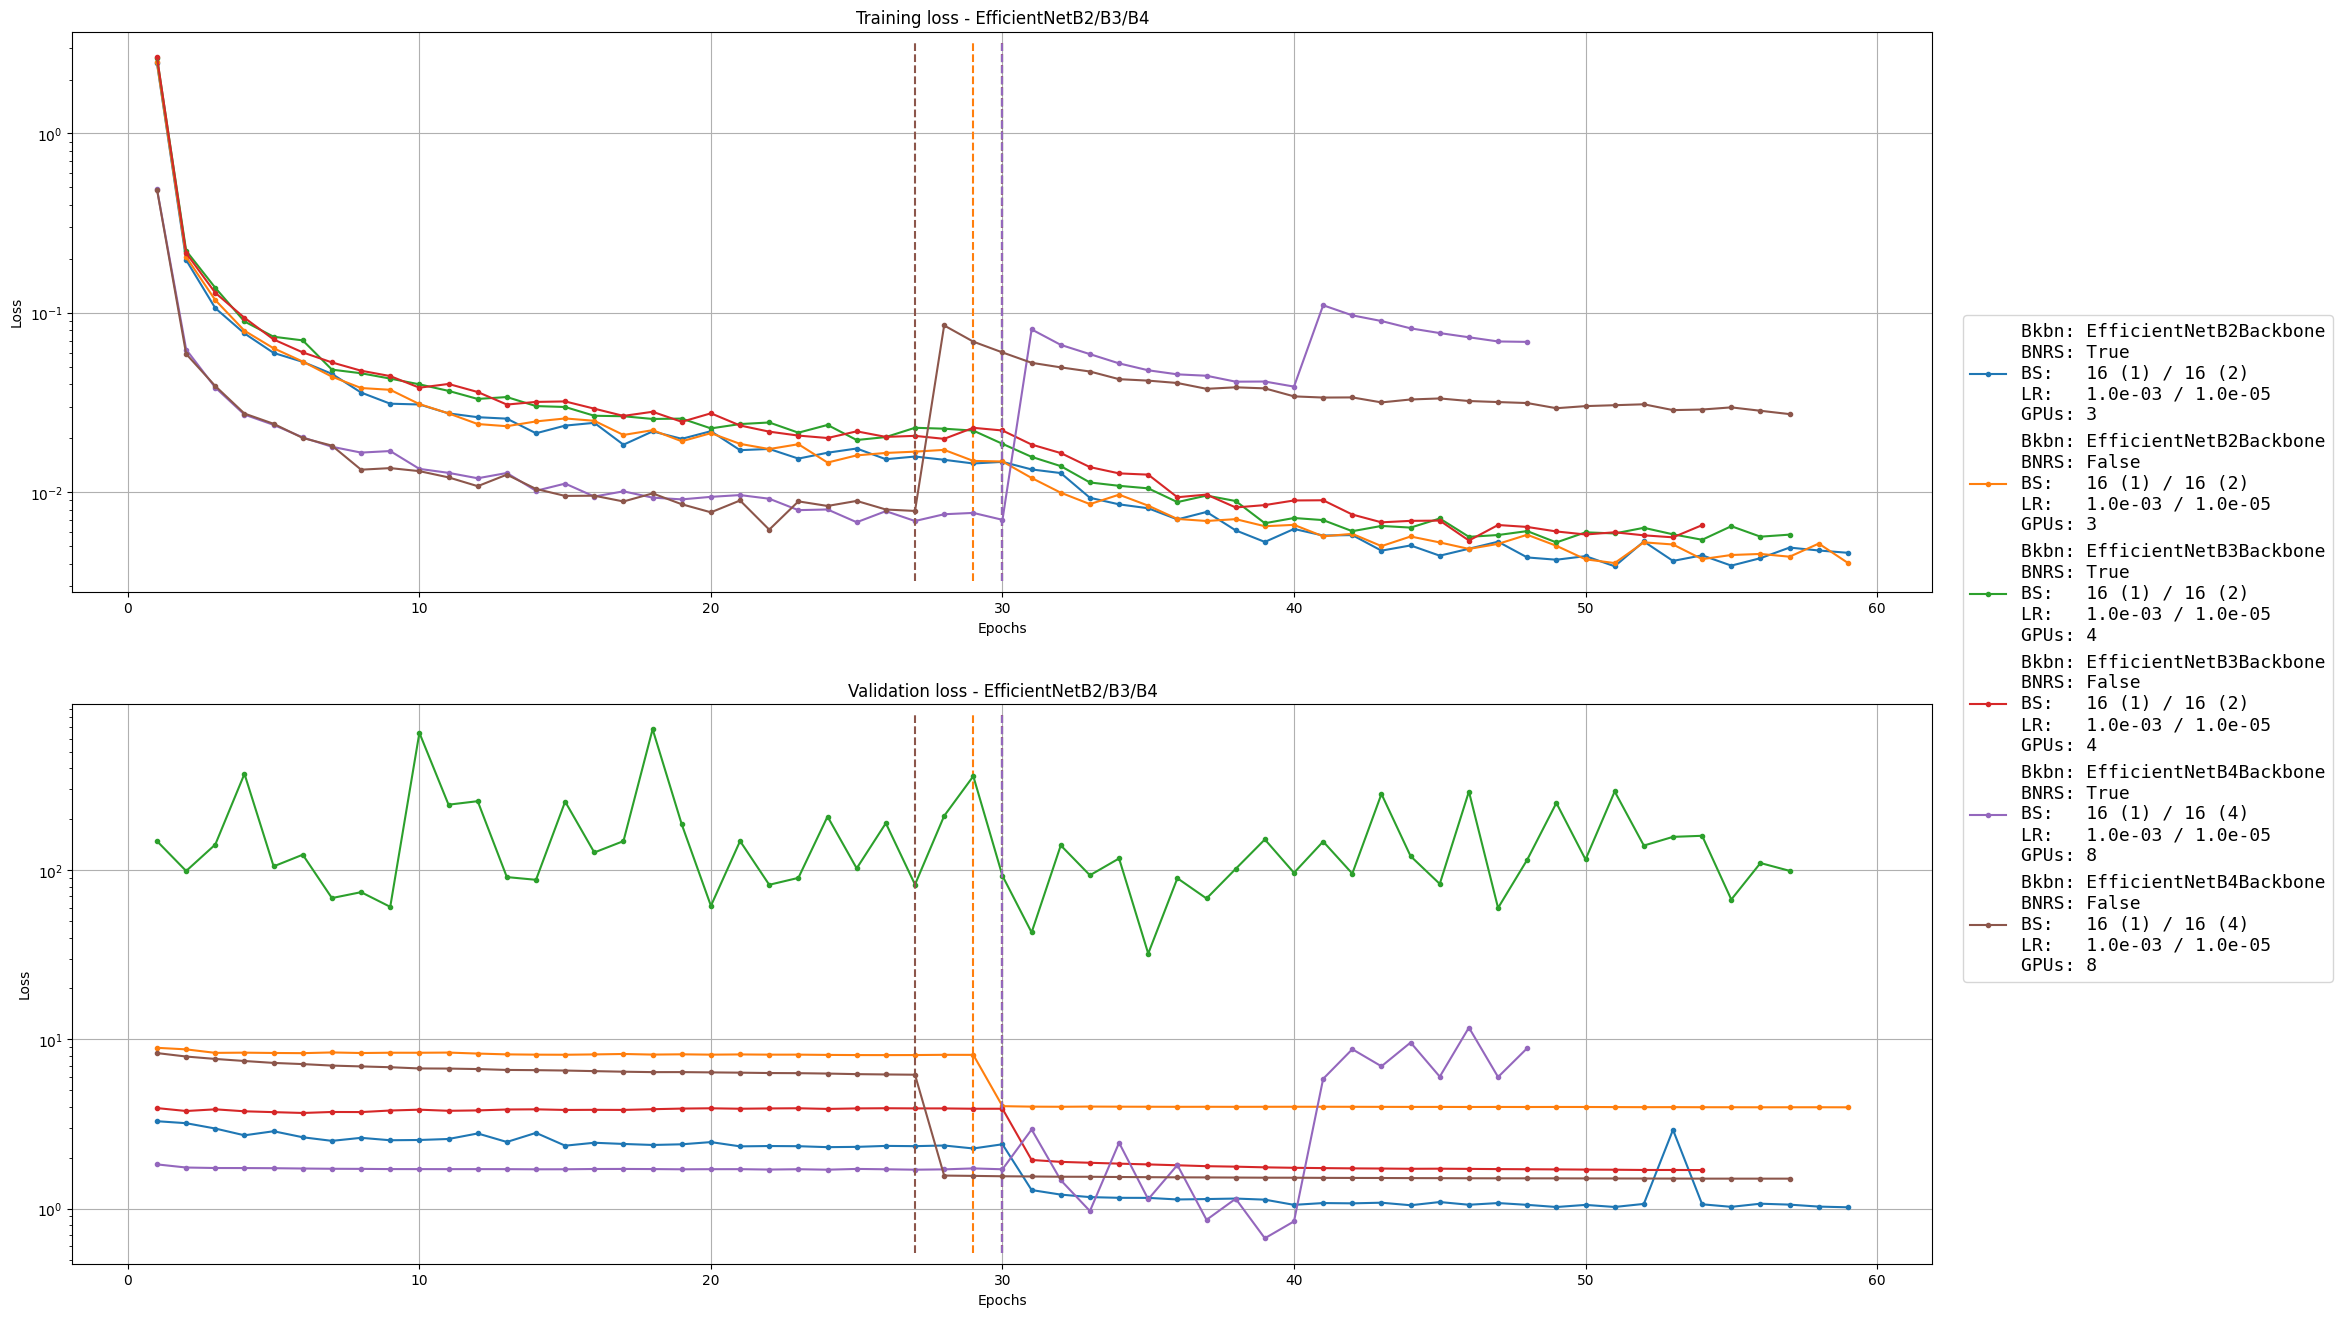

In [40]:
exp_data_list = []

for exp_data in exp_data_all["ret_train_extra"].values():
    exp_data_list.append(exp_data["exp_000"])
    exp_data_list.append(exp_data["exp_001"])

###

fig, axs = plt.subplots(figsize=(24, 16), nrows=2)

cmap = mpl.colormaps["tab10"]
#color_list = [cmap(x) for x in np.linspace(0, 1, len(exp_data_list))]
color_list = [cmap(x) for x in np.linspace(0, 1, 10)]

for exp_data_idx, exp_data in enumerate(exp_data_list):

    backbone = exp_data["settings"]["backbone"]["class"]
    bnrs = utils.dict.chain_get(exp_data, "settings", "backbone", "batchnorm_track_runnning_stats", default=True)
    batch_size_1 = exp_data["settings"]["stage_1"]["data_loading"]["batch_size"]
    batch_size_2 = exp_data["settings"]["stage_2"]["data_loading"]["batch_size"]
    #grad_acc_iters_1 = utils.dict.chain_get(exp_data, "settings", "stage_1", "max_acc_iter", default=1)
    grad_acc_iters_1 = utils.dict.chain_get(exp_data, "settings", "stage_1", "data_loading", "grad_acc_iters", default=1)
    #grad_acc_iters_2 = utils.dict.chain_get(exp_data, "settings", "stage_2", "max_acc_iter", default=1)
    grad_acc_iters_2 = utils.dict.chain_get(exp_data, "settings", "stage_2", "data_loading", "grad_acc_iters", default=1)
    lr_1 = exp_data["settings"]["stage_1"]["optimizer"]["lr"]
    lr_2 = exp_data["settings"]["stage_2"]["optimizer"]["lr"]
    num_gpus = len(exp_data["settings"]["gpu_usage"])

    title_lines = []
    title_lines.append("Bkbn: {:s}".format(backbone))
    title_lines.append("BNRS: {:s}".format(str(bnrs)))
    title_lines.append("BS:   {:2d} ({:d}) / {:2d} ({:d})".format(
        batch_size_1 * grad_acc_iters_1,
        grad_acc_iters_1,
        batch_size_2 * grad_acc_iters_2,
        grad_acc_iters_2
    ))
    title_lines.append("LR:   {:.1e} / {:.1e}".format(
        lr_1,
        lr_2
    ))
    title_lines.append("GPUs: {:d}".format(num_gpus))

    label = "\n".join(title_lines)
    
    mean_train_loss_list =\
        list(map(np.mean, exp_data["results"]["stage_1"]["train_mean_loss_list"])) +\
        list(map(np.mean, exp_data["results"]["stage_2"]["train_mean_loss_list"]))

    mean_val_loss_list =\
        list(map(np.mean, exp_data["results"]["stage_1"]["val_mean_loss_list"])) +\
        list(map(np.mean, exp_data["results"]["stage_2"]["val_mean_loss_list"]))
    
    stage_1_epochs = exp_data["results"]["stage_1"]["num_epochs"]

    color = color_list[exp_data_idx]

    axs[0].plot(range(1, len(mean_train_loss_list) + 1), mean_train_loss_list, label=label, color=color, marker=".")
    axs[1].plot(range(1, len(mean_val_loss_list) + 1), mean_val_loss_list, label=label, color=color, marker=".")

    axs[0].axvline(stage_1_epochs, ymin=0.02, ymax=0.98, color=color, linestyle="--")
    axs[1].axvline(stage_1_epochs, ymin=0.02, ymax=0.98, color=color, linestyle="--")

for ax in axs:

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")

    ax.set_yscale("log")

    ax.grid()

axs[0].set_title("Training loss - EfficientNetB2/B3/B4")
axs[1].set_title("Validation loss - EfficientNetB2/B3/B4")

#

plt.legend(prop={'family': 'monospace', "size": 13}, bbox_to_anchor=(1.22, 1.71))

#

plt.show()

In [ ]:
exp_data_list = []

for exp_data in exp_data_all["resnet_50"].values():
    exp_data_list.append(exp_data)

###

fig, axs = plt.subplots(figsize=(24, 16), nrows=2)

cmap = mpl.colormaps["tab20"]
color_list = [cmap(x) for x in np.linspace(0, 1, len(exp_data_list))]

for exp_data_idx, exp_data in enumerate(exp_data_list):

    batch_size_1 = exp_data["settings"]["stage_1"]["data_loading"]["batch_size"]
    batch_size_2 = exp_data["settings"]["stage_2"]["data_loading"]["batch_size"]
    grad_acc_iters_1 = utils.dict.chain_get(exp_data, "settings", "stage_1", "max_acc_iter", default=1)
    grad_acc_iters_2 = utils.dict.chain_get(exp_data, "settings", "stage_2", "max_acc_iter", default=1)
    lr_1 = exp_data["settings"]["stage_1"]["optimizer"]["lr"]
    lr_2 = exp_data["settings"]["stage_2"]["optimizer"]["lr"]
    num_gpus = len(exp_data["settings"]["gpu_usage"])

    exp_name = "BS: {:2d} ({:d}) / {:2d} ({:d}) - LR: {:.1e} / {:.1e} - GPUs: {:d}".format(
        batch_size_1 * grad_acc_iters_1,
        grad_acc_iters_1,
        batch_size_2 * grad_acc_iters_2,
        grad_acc_iters_2,
        lr_1,
        lr_2,
        num_gpus
    )
    
    mean_train_loss_list =\
        list(map(np.mean, exp_data["results"]["stage_1"]["train_mean_loss_list"])) +\
        list(map(np.mean, exp_data["results"]["stage_2"]["train_mean_loss_list"]))

    mean_val_loss_list =\
        list(map(np.mean, exp_data["results"]["stage_1"]["val_mean_loss_list"])) +\
        list(map(np.mean, exp_data["results"]["stage_2"]["val_mean_loss_list"]))
    
    stage_1_epochs = exp_data["results"]["stage_1"]["num_epochs"]

    color = color_list[exp_data_idx]

    axs[0].plot(range(1, len(mean_train_loss_list) + 1), mean_train_loss_list, label=exp_name, color=color, marker=".")
    axs[1].plot(range(1, len(mean_val_loss_list) + 1), mean_val_loss_list, label=exp_name, color=color, marker=".")

    axs[0].axvline(stage_1_epochs, ymin=0.02, ymax=0.98, color=color, linestyle="--")
    axs[1].axvline(stage_1_epochs, ymin=0.02, ymax=0.98, color=color, linestyle="--")

for ax in axs:

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")

    ax.set_yscale("log")

    ax.grid()

axs[0].legend(prop={'family': 'monospace'}, bbox_to_anchor=(1.28, 0.08))

axs[0].set_title("Training loss - ResNet50Backbone")
axs[1].set_title("Validation loss - ResNet50Backbone")

plt.show()

In [ ]:
exp_data_list = []

for exp_data in exp_data_all["efficientnet_b3"].values():
    exp_data_list.append(exp_data)

###

fig, axs = plt.subplots(figsize=(24, 16), nrows=2)

cmap = mpl.colormaps["tab20"]
color_list = [cmap(x) for x in np.linspace(0, 1, len(exp_data_list))]

for exp_data_idx, exp_data in enumerate(exp_data_list):

    batch_size_1 = exp_data["settings"]["stage_1"]["data_loading"]["batch_size"]
    batch_size_2 = exp_data["settings"]["stage_2"]["data_loading"]["batch_size"]
    grad_acc_iters_1 = utils.dict.chain_get(exp_data, "settings", "stage_1", "max_acc_iter", default=1)
    grad_acc_iters_2 = utils.dict.chain_get(exp_data, "settings", "stage_2", "max_acc_iter", default=1)
    lr_1 = exp_data["settings"]["stage_1"]["optimizer"]["lr"]
    lr_2 = exp_data["settings"]["stage_2"]["optimizer"]["lr"]
    num_gpus = len(exp_data["settings"]["gpu_usage"])

    exp_name = "BS: {:2d} ({:d}) / {:2d} ({:d}) - LR: {:.1e} / {:.1e} - GPUs: {:d}".format(
        batch_size_1 * grad_acc_iters_1,
        grad_acc_iters_1,
        batch_size_2 * grad_acc_iters_2,
        grad_acc_iters_2,
        lr_1,
        lr_2,
        num_gpus
    )

    mean_train_loss_list =\
        list(map(np.mean, exp_data["results"]["stage_1"]["train_mean_loss_list"])) +\
        list(map(np.mean, exp_data["results"]["stage_2"]["train_mean_loss_list"]))

    mean_val_loss_list =\
        list(map(np.mean, exp_data["results"]["stage_1"]["val_mean_loss_list"])) +\
        list(map(np.mean, exp_data["results"]["stage_2"]["val_mean_loss_list"]))
    
    stage_1_epochs = exp_data["results"]["stage_1"]["num_epochs"]

    color = color_list[exp_data_idx]

    axs[0].plot(range(1, len(mean_train_loss_list) + 1), mean_train_loss_list, label=exp_name, color=color, marker=".")
    axs[1].plot(range(1, len(mean_val_loss_list) + 1), mean_val_loss_list, label=exp_name, color=color, marker=".")

    axs[0].axvline(stage_1_epochs, ymin=0.02, ymax=0.98, color=color, linestyle="--")
    axs[1].axvline(stage_1_epochs, ymin=0.02, ymax=0.98, color=color, linestyle="--")

for ax in axs:

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")

    ax.set_yscale("log")

    ax.grid()

axs[0].legend(prop={'family': 'monospace'}, bbox_to_anchor=(1.28, 0.14))

axs[0].set_title("Training loss - EfficientNetB3Backbone")
axs[1].set_title("Validation loss - EfficientNetB3Backbone")

plt.show()

In [ ]:
exp_data_list = []

for exp_data in exp_data_all["convnext_t"].values():
    exp_data_list.append(exp_data)

###

fig, axs = plt.subplots(figsize=(24, 16), nrows=2)

cmap = mpl.colormaps["tab20"]
color_list = [cmap(x) for x in np.linspace(0, 1, len(exp_data_list))]

for exp_data_idx, exp_data in enumerate(exp_data_list):

    batch_size_1 = exp_data["settings"]["stage_1"]["data_loading"]["batch_size"]
    batch_size_2 = exp_data["settings"]["stage_2"]["data_loading"]["batch_size"]
    grad_acc_iters_1 = utils.dict.chain_get(exp_data, "settings", "stage_1", "max_acc_iter", default=1)
    grad_acc_iters_2 = utils.dict.chain_get(exp_data, "settings", "stage_2", "max_acc_iter", default=1)
    lr_1 = exp_data["settings"]["stage_1"]["optimizer"]["lr"]
    lr_2 = exp_data["settings"]["stage_2"]["optimizer"]["lr"]
    num_gpus = len(exp_data["settings"]["gpu_usage"])

    exp_name = "BS: {:2d} ({:d}) / {:2d} ({:d}) - LR: {:.1e} / {:.1e} - GPUs: {:d}".format(
        batch_size_1 * grad_acc_iters_1,
        grad_acc_iters_1,
        batch_size_2 * grad_acc_iters_2,
        grad_acc_iters_2,
        lr_1,
        lr_2,
        num_gpus
    )
    
    mean_train_loss_list =\
        list(map(np.mean, exp_data["results"]["stage_1"]["train_mean_loss_list"])) +\
        list(map(np.mean, exp_data["results"]["stage_2"]["train_mean_loss_list"]))

    mean_val_loss_list =\
        list(map(np.mean, exp_data["results"]["stage_1"]["val_mean_loss_list"])) +\
        list(map(np.mean, exp_data["results"]["stage_2"]["val_mean_loss_list"]))
    
    stage_1_epochs = exp_data["results"]["stage_1"]["num_epochs"]

    color = color_list[exp_data_idx]

    axs[0].plot(range(1, len(mean_train_loss_list) + 1), mean_train_loss_list, label=exp_name, color=color, marker=".")
    axs[1].plot(range(1, len(mean_val_loss_list) + 1), mean_val_loss_list, label=exp_name, color=color, marker=".")

    axs[0].axvline(stage_1_epochs, ymin=0.02, ymax=0.98, color=color, linestyle="--")
    axs[1].axvline(stage_1_epochs, ymin=0.02, ymax=0.98, color=color, linestyle="--")

for ax in axs:

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")

    ax.set_yscale("log")

    ax.grid()

axs[0].legend(prop={'family': 'monospace'}, bbox_to_anchor=(1.28, 0.16))

axs[0].set_title("Training loss - ConvNeXtTinyBackbone")
axs[1].set_title("Validation loss - ConvNeXtTinyBackbone")

plt.show()

---

# Loss DataFrame

In [ ]:
exp_data_list = []

for exp_data_all_2 in exp_data_all.values():
    for exp_data in exp_data_all_2.values():
        exp_data_list.append(exp_data)

###

df_records = []

for exp_data in exp_data_list:

    df_record = {}

    # Params

    df_record["backbone"] = exp_data["settings"]["backbone"]["class"]

    stage_1_batch_size = exp_data["settings"]["stage_1"]["data_loading"]["batch_size"]
    stage_2_batch_size = exp_data["settings"]["stage_2"]["data_loading"]["batch_size"]

    stage_1_max_acc_iter = utils.dict.chain_get(
        exp_data,
        "settings", "stage_1", "max_acc_iter",
        default=1
    )
    stage_2_max_acc_iter = utils.dict.chain_get(
        exp_data,
        "settings", "stage_2", "max_acc_iter",
        default=1
    )

    df_record["loading_batch_size"] = stage_1_batch_size * stage_1_max_acc_iter

    df_record["stage_1_grad_acc_iters"] = stage_1_max_acc_iter
    df_record["stage_2_grad_acc_iters"] = stage_2_max_acc_iter

    df_record["stage_1_lr"] = exp_data["settings"]["stage_1"]["optimizer"]["lr"]
    df_record["stage_2_lr"] = exp_data["settings"]["stage_2"]["optimizer"]["lr"]

    df_record["num_gpus"] = len(exp_data["settings"]["gpu_usage"])

    # Results

    df_record["train_mean_loss"] = np.mean(exp_data["results"]["stage_2"]["train_mean_loss_list"])
    df_record["val_mean_loss"] = np.mean(exp_data["results"]["stage_2"]["val_mean_loss_list"])
    df_record["test_mean_loss"] = np.mean(exp_data["results"]["test"]["test_mean_loss"])

    df_records.append(df_record)

In [ ]:
df = pd.DataFrame.from_records(df_records)

In [ ]:
df.sort_values("test_mean_loss")

---

# Extra

In [ ]:
ord_df = df.sort_values("test_mean_loss", ascending=False)
ord_df = ord_df.reset_index(drop=True)

In [ ]:
ord_df

In [ ]:
plt.figure(figsize=(24, 8))

###

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]

    plt.bar(ord_df_filt.index, ord_df_filt["test_mean_loss"], width=0.8, label=backbone)

plt.yscale("log")
plt.legend()

###

plt.xticks([])
plt.title("Test Loss")

###

plt.show()

In [ ]:
plt.figure(figsize=(24, 8))

###

bar_width = 0.8

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]
    
    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "EfficientNetB3Backbone": backbone_color = np.asarray([255/256, 153/256, 0/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([51/256, 153/256, 51/256])

    plt.bar(np.asarray(ord_df_filt.index) - bar_width/3, ord_df_filt["train_mean_loss"], width=bar_width/3, color=backbone_color, alpha=0.5)
    plt.bar(np.asarray(ord_df_filt.index), ord_df_filt["val_mean_loss"], width=bar_width/3, color=backbone_color, alpha=0.75)
    plt.bar(np.asarray(ord_df_filt.index) + bar_width/3, ord_df_filt["test_mean_loss"], width=bar_width/3, label=backbone, color=backbone_color, alpha=1)

plt.yscale("log")
plt.legend()

###

plt.xticks([])
plt.title("Train/Val/Test Loss")

###

plt.show()

In [ ]:
ord_df

In [ ]:
print("\\begin{tabular}{l", end="")
for _ in range(len(ord_df)):
    print("c", end="")
print("}", end="")
print()

###

print("Batch Size", end="")
for batch_size in ord_df["loading_batch_size"]:
    print(" & {:d}".format(batch_size), end="")
print(" \\\\")

###

print("Grad Accum. Iters", end="")
for stage_1_grad_acc_iters, stage_2_grad_acc_iters in zip(ord_df["stage_1_grad_acc_iters"], ord_df["stage_2_grad_acc_iters"]):
    print(" & {:d}".format(stage_2_grad_acc_iters), end="")
print(" \\\\")

###

print("Learning Rate (S1)", end="")
for stage_1_lr in ord_df["stage_1_lr"]:
    print(" & {:.1e}".format(float(stage_1_lr)), end="")
print(" \\\\")

###

print("Learning Rate (S2)", end="")
for stage_2_lr in ord_df["stage_2_lr"]:
    print(" & {:.1e}".format(float(stage_2_lr)), end="")
print(" \\\\")

###

print("Number of GPUs", end="")
for num_gpus in ord_df["num_gpus"]:
    print(" & {:d}".format(num_gpus), end="")

In [ ]:
for stage_1_grad_acc_iters, stage_2_grad_acc_iters in zip(ord_df["stage_1_grad_acc_iters"], ord_df["stage_2_grad_acc_iters"]):
    print("{:d} & ".format(stage_2_grad_acc_iters), end="")

In [ ]:
ord_df["stage_1_lr"] = ord_df["stage_1_lr"].apply(lambda f: "{:.1e}".format(f))
ord_df["stage_2_lr"] = ord_df["stage_2_lr"].apply(lambda f: "{:.1e}".format(f))

In [ ]:
ord_df

In [ ]:
print(ord_df.to_latex())